# Preprocessing4 - lowess filter

## preprocess4/input3

In [1]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T

import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = '../DL_model/dataset/preprocess4/input3/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))
    df_demograph = pd.read_csv('../DL_model/caseids_age_gender.csv')
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('../DL_model/caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('../DL_model/caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('../DL_model/caseid_val_new', 'rb'))
    
    non_lis = []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []
    age_train_pacu, gender_train_pacu = [], []
    age_test_pacu, gender_test_pacu = [], []
    age_val_pacu, gender_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        if cnt<=1800:
            continue
        if cnt>3600:
            break
            
            
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
        row_demo = df_demograph[df_demograph['caseids']==row['caseids']].iloc[0]
            

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/pacu_'+row['caseids']
        # 한 NRS에 대해 23개의 input 확인
        for i in range(0,30):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                ppg_inp = np.copy(ppg_per_NRS[start_idx:end_idx])
                if np.sum(np.isnan(ppg_inp))!=0:
                    ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                
                pleth_inp = ppg_inp - smooth(ppg_inp)
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = np.copy(ecg_per_NRS[start_idx:end_idx])
                if np.sum(np.isnan(ecg_inp))!=0:
                    ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                
                ecg_inp = ecg_inp - smooth(ecg_inp)
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                pickle.dump([pleth_inp, ecg_inp],  open(save_path+'_{}'.format(i), 'wb'))
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    age_test_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_test_pacu.append(1)
                    else:
                        gender_test_pacu.append(0)
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    age_val_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_val_pacu.append(1)
                    else:
                        gender_val_pacu.append(0)                    
                    x_val_pacu.append([pleth_inp, ecg_inp])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    age_train_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_train_pacu.append(1)
                    else:
                        gender_train_pacu.append(0)                    
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_lis.append(row['caseids'])
                    
        print('completed')
        
        
    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)
    
    age_train_pacu = np.array(age_train_pacu, int)
    age_test_pacu = np.array(age_test_pacu, int)
    age_val_pacu = np.array(age_val_pacu, int)
    gender_train_pacu = np.array(gender_train_pacu, int)
    gender_test_pacu = np.array(gender_test_pacu, int)
    gender_val_pacu = np.array(gender_val_pacu, int)
    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu2.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu2.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu2.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu2.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu2.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu2.npz', y_val_pacu)
    
    np.savez_compressed(input_path+'age_train_pacu2.npz', age_train_pacu)
    np.savez_compressed(input_path+'age_test_pacu2.npz', age_test_pacu)
    np.savez_compressed(input_path+'age_val_pacu2.npz', age_val_pacu)    
    np.savez_compressed(input_path+'gender_train_pacu2.npz', gender_train_pacu)
    np.savez_compressed(input_path+'gender_test_pacu2.npz', gender_test_pacu)
    np.savez_compressed(input_path+'gender_val_pacu2.npz', gender_val_pacu)    
    
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1801/7253 ...completed
loading data 1802/7253 ...completed
loading data 1803/7253 ...completed
loading data 1804/7253 ...completed
loading data 1805/7253 ...completed
loading data 1806/7253 ...completed
loading data 1807/7253 ...completed
loading data 1808/7253 ...completed
loading data 1809/7253 ...completed
loading data 1810/7253 ...completed
loading data 1811/7253 ...completed
loading data 1812/7253 ...completed
loading data 1813/7253 ...completed
loading data 1814/7253 ...completed
loading data 1815/7253 ...completed
loading data 1816/7253 ...completed
loading data 1817/7253 ...completed
loading data 1818/7253 ...completed
loading data 1819/7253 ...completed
loading data 1820/7253 ...completed
loading data 1821/7253 ...completed
loading data 1822/7253 ...completed
loading data 1823/7253 ...completed
loading data 1824/7253 ...completed
loading data 1825/7253 ...completed
loading data 1826/7253 ...completed
loading data 1827/7253 ...completed
loading data 1828/7253 ...co

loading data 2257/7253 ...completed
loading data 2258/7253 ...completed
loading data 2259/7253 ...completed
loading data 2260/7253 ...completed
loading data 2261/7253 ...completed
loading data 2262/7253 ...completed
loading data 2263/7253 ...completed
loading data 2264/7253 ...completed
loading data 2265/7253 ...completed
loading data 2266/7253 ...completed
loading data 2267/7253 ...completed
loading data 2268/7253 ...completed
loading data 2269/7253 ...completed
loading data 2270/7253 ...completed
loading data 2271/7253 ...completed
loading data 2272/7253 ...completed
loading data 2273/7253 ...completed
loading data 2274/7253 ...completed
loading data 2275/7253 ...completed
loading data 2276/7253 ...completed
loading data 2277/7253 ...completed
loading data 2278/7253 ...completed
loading data 2279/7253 ...completed
loading data 2280/7253 ...completed
loading data 2281/7253 ...completed
loading data 2282/7253 ...completed
loading data 2283/7253 ...completed
loading data 2284/7253 ...co

loading data 2711/7253 ...completed
loading data 2712/7253 ...completed
loading data 2713/7253 ...completed
loading data 2714/7253 ...completed
loading data 2715/7253 ...completed
loading data 2716/7253 ...completed
loading data 2717/7253 ...completed
loading data 2718/7253 ...completed
loading data 2719/7253 ...completed
loading data 2720/7253 ...completed
loading data 2721/7253 ...completed
loading data 2722/7253 ...completed
loading data 2723/7253 ...completed
loading data 2724/7253 ...completed
loading data 2725/7253 ...completed
loading data 2726/7253 ...completed
loading data 2727/7253 ...completed
loading data 2728/7253 ...completed
loading data 2729/7253 ...completed
loading data 2730/7253 ...completed
loading data 2731/7253 ...completed
loading data 2732/7253 ...completed
loading data 2733/7253 ...completed
loading data 2734/7253 ...completed
loading data 2735/7253 ...completed
loading data 2736/7253 ...completed
loading data 2737/7253 ...completed
loading data 2738/7253 ...co

loading data 3167/7253 ...completed
loading data 3168/7253 ...completed
loading data 3169/7253 ...completed
loading data 3170/7253 ...completed
loading data 3171/7253 ...completed
loading data 3172/7253 ...completed
loading data 3173/7253 ...completed
loading data 3174/7253 ...completed
loading data 3175/7253 ...completed
loading data 3176/7253 ...completed
loading data 3177/7253 ...completed
loading data 3178/7253 ...completed
loading data 3179/7253 ...completed
loading data 3180/7253 ...completed
loading data 3181/7253 ...completed
loading data 3182/7253 ...completed
loading data 3183/7253 ...completed
loading data 3184/7253 ...completed
loading data 3185/7253 ...completed
loading data 3186/7253 ...completed
loading data 3187/7253 ...completed
loading data 3188/7253 ...completed
loading data 3189/7253 ...completed
loading data 3190/7253 ...completed
loading data 3191/7253 ...completed
loading data 3192/7253 ...completed
loading data 3193/7253 ...completed
loading data 3194/7253 ...co

loading data 3395/7253 ...completed
loading data 3396/7253 ...completed
loading data 3397/7253 ...completed
loading data 3398/7253 ...completed
loading data 3399/7253 ...completed
loading data 3400/7253 ...completed
loading data 3401/7253 ...completed
loading data 3402/7253 ...completed
loading data 3403/7253 ...completed
loading data 3404/7253 ...completed
loading data 3405/7253 ...completed
loading data 3406/7253 ...completed
loading data 3407/7253 ...completed
loading data 3408/7253 ...completed
loading data 3409/7253 ...completed
loading data 3410/7253 ...completed
loading data 3411/7253 ...completed
loading data 3412/7253 ...completed
loading data 3413/7253 ...completed
loading data 3414/7253 ...completed
loading data 3415/7253 ...completed
loading data 3416/7253 ...completed
loading data 3417/7253 ...completed
loading data 3418/7253 ...completed
loading data 3419/7253 ...completed
loading data 3420/7253 ...completed
loading data 3421/7253 ...completed
loading data 3422/7253 ...co

## preprocess4/ ECG 0~1

In [ ]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T

import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = '../DL_model/dataset/preprocess4/ECG_0-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))
    df_demograph = pd.read_csv('../DL_model/caseids_age_gender.csv')
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('../DL_model/caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('../DL_model/caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('../DL_model/caseid_val_new', 'rb'))
    
    non_lis = []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []
    age_train_pacu, gender_train_pacu = [], []
    age_test_pacu, gender_test_pacu = [], []
    age_val_pacu, gender_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        if cnt<=1800:
            continue
        if cnt>3600:
            break
            
            
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
        row_demo = df_demograph[df_demograph['caseids']==row['caseids']].iloc[0]
            

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/pacu_'+row['caseids']
        # 한 NRS에 대해 23개의 input 확인
        for i in range(0,30):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                
                
                # input의 normalization
                ppg_inp = np.copy(ppg_per_NRS[start_idx:end_idx])
                if np.sum(np.isnan(ppg_inp))!=0:
                    ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                
                pleth_inp = ppg_inp - smooth(ppg_inp)
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = np.copy(ecg_per_NRS[start_idx:end_idx])
                if np.sum(np.isnan(ecg_inp))!=0:
                    ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                
                ecg_inp = ecg_inp - smooth(ecg_inp)
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                pickle.dump([pleth_inp, ecg_inp],  open(save_path+'_{}'.format(i), 'wb'))
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    age_test_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_test_pacu.append(1)
                    else:
                        gender_test_pacu.append(0)
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    age_val_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_val_pacu.append(1)
                    else:
                        gender_val_pacu.append(0)                    
                    x_val_pacu.append([pleth_inp, ecg_inp])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    age_train_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_train_pacu.append(1)
                    else:
                        gender_train_pacu.append(0)                    
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_lis.append(row['caseids'])
                    
        print('completed')
        
        
    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)
    
    age_train_pacu = np.array(age_train_pacu, int)
    age_test_pacu = np.array(age_test_pacu, int)
    age_val_pacu = np.array(age_val_pacu, int)
    gender_train_pacu = np.array(gender_train_pacu, int)
    gender_test_pacu = np.array(gender_test_pacu, int)
    gender_val_pacu = np.array(gender_val_pacu, int)
    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu2.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu2.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu2.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu2.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu2.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu2.npz', y_val_pacu)
    
    np.savez_compressed(input_path+'age_train_pacu2.npz', age_train_pacu)
    np.savez_compressed(input_path+'age_test_pacu2.npz', age_test_pacu)
    np.savez_compressed(input_path+'age_val_pacu2.npz', age_val_pacu)    
    np.savez_compressed(input_path+'gender_train_pacu2.npz', gender_train_pacu)
    np.savez_compressed(input_path+'gender_test_pacu2.npz', gender_test_pacu)
    np.savez_compressed(input_path+'gender_val_pacu2.npz', gender_val_pacu)    
    
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

## preprocess3/input3-3

In [6]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = '../DL_model/dataset/preprocess3/input3-3/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if True:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))
    df_demograph = pd.read_csv('../DL_model/caseids_age_gender.csv')
    

    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('../DL_model/caseid_test', 'rb'))
    caseid_train = pickle.load(open('../DL_model/caseid_train', 'rb'))
    caseid_val = pickle.load(open('../DL_model/caseid_val', 'rb'))
    

    x_train_pacu, y_train_pacu = 0, 0
    x_test_pacu, y_test_pacu = 0, 0
    x_val_pacu, y_val_pacu = 0, 0

    cnt = 0
    wrong = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
            
        if not row['caseids'] in df_demograph['caseids'].tolist():
            wrong+=1
            continue

        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu+=1

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    x_val_pacu+=1
                    
                else:
                    x_train_pacu+=1
        print('done')

    
    
print('size of training set(pacu):', (x_train_pacu))
print('size of validation set(pacu):', (x_val_pacu))
print('size of test set(pacu):', (x_test_pacu))

loading data 1/7253 ...done
loading data 2/7253 ...done
loading data 3/7253 ...done
loading data 4/7253 ...done
loading data 5/7253 ...done
loading data 6/7253 ...done
loading data 7/7253 ...done
loading data 8/7253 ...done
loading data 9/7253 ...done
loading data 10/7253 ...done
loading data 11/7253 ...done
loading data 12/7253 ...done
loading data 13/7253 ...done
loading data 14/7253 ...done
loading data 15/7253 ...done
loading data 16/7253 ...done
loading data 17/7253 ...done
loading data 18/7253 ...done
loading data 19/7253 ...done
loading data 20/7253 ...done
loading data 21/7253 ...done
loading data 22/7253 ...done
loading data 23/7253 ...done
loading data 24/7253 ...done
loading data 25/7253 ...done
loading data 26/7253 ...done
loading data 27/7253 ...done
loading data 28/7253 ...done
loading data 29/7253 ...done
loading data 30/7253 ...done
loading data 31/7253 ...done
loading data 32/7253 ...done
loading data 33/7253 ...done
loading data 34/7253 ...done
loading data 35/7253 ..

loading data 297/7253 ...done
loading data 298/7253 ...done
loading data 299/7253 ...done
loading data 300/7253 ...done
loading data 301/7253 ...done
loading data 302/7253 ...done
loading data 303/7253 ...done
loading data 304/7253 ...done
loading data 305/7253 ...done
loading data 306/7253 ...done
loading data 307/7253 ...done
loading data 308/7253 ...done
loading data 309/7253 ...done
loading data 310/7253 ...done
loading data 311/7253 ...done
loading data 312/7253 ...done
loading data 313/7253 ...done
loading data 314/7253 ...done
loading data 315/7253 ...done
loading data 316/7253 ...done
loading data 317/7253 ...done
loading data 318/7253 ...done
loading data 319/7253 ...done
loading data 320/7253 ...done
loading data 321/7253 ...done
loading data 322/7253 ...done
loading data 323/7253 ...done
loading data 324/7253 ...done
loading data 325/7253 ...done
loading data 326/7253 ...done
loading data 327/7253 ...done
loading data 328/7253 ...done
loading data 329/7253 ...done
loading da

loading data 638/7253 ...done
loading data 639/7253 ...done
loading data 640/7253 ...done
loading data 641/7253 ...done
loading data 642/7253 ...done
loading data 643/7253 ...done
loading data 644/7253 ...done
loading data 645/7253 ...done
loading data 646/7253 ...done
loading data 647/7253 ...done
loading data 648/7253 ...done
loading data 649/7253 ...done
loading data 650/7253 ...done
loading data 651/7253 ...done
loading data 652/7253 ...done
loading data 653/7253 ...done
loading data 654/7253 ...done
loading data 655/7253 ...done
loading data 656/7253 ...done
loading data 657/7253 ...done
loading data 658/7253 ...done
loading data 659/7253 ...done
loading data 660/7253 ...done
loading data 661/7253 ...done
loading data 662/7253 ...done
loading data 663/7253 ...done
loading data 664/7253 ...done
loading data 665/7253 ...done
loading data 666/7253 ...done
loading data 667/7253 ...done
loading data 668/7253 ...done
loading data 669/7253 ...done
loading data 670/7253 ...done
loading da

loading data 986/7253 ...done
loading data 987/7253 ...done
loading data 988/7253 ...done
loading data 989/7253 ...done
loading data 990/7253 ...done
loading data 991/7253 ...done
loading data 992/7253 ...done
loading data 993/7253 ...done
loading data 994/7253 ...done
loading data 995/7253 ...done
loading data 996/7253 ...done
loading data 997/7253 ...done
loading data 998/7253 ...done
loading data 999/7253 ...done
loading data 1000/7253 ...done
loading data 1001/7253 ...done
loading data 1002/7253 ...done
loading data 1003/7253 ...done
loading data 1004/7253 ...done
loading data 1005/7253 ...done
loading data 1006/7253 ...done
loading data 1007/7253 ...done
loading data 1008/7253 ...done
loading data 1009/7253 ...done
loading data 1010/7253 ...done
loading data 1011/7253 ...done
loading data 1012/7253 ...done
loading data 1013/7253 ...done
loading data 1014/7253 ...done
loading data 1015/7253 ...done
loading data 1016/7253 ...done
loading data 1017/7253 ...done
loading data 1018/7253

loading data 1355/7253 ...done
loading data 1356/7253 ...done
loading data 1357/7253 ...done
loading data 1358/7253 ...done
loading data 1359/7253 ...done
loading data 1360/7253 ...done
loading data 1361/7253 ...done
loading data 1362/7253 ...done
loading data 1363/7253 ...done
loading data 1364/7253 ...done
loading data 1365/7253 ...done
loading data 1366/7253 ...done
loading data 1367/7253 ...done
loading data 1368/7253 ...done
loading data 1369/7253 ...done
loading data 1370/7253 ...done
loading data 1371/7253 ...done
loading data 1372/7253 ...done
loading data 1373/7253 ...done
loading data 1374/7253 ...done
loading data 1375/7253 ...done
loading data 1376/7253 ...done
loading data 1377/7253 ...done
loading data 1378/7253 ...done
loading data 1379/7253 ...done
loading data 1380/7253 ...done
loading data 1381/7253 ...done
loading data 1382/7253 ...done
loading data 1383/7253 ...done
loading data 1384/7253 ...done
loading data 1385/7253 ...done
loading data 1386/7253 ...done
loading 

loading data 1815/7253 ...done
loading data 1816/7253 ...done
loading data 1817/7253 ...done
loading data 1818/7253 ...done
loading data 1819/7253 ...done
loading data 1820/7253 ...done
loading data 1821/7253 ...done
loading data 1822/7253 ...done
loading data 1823/7253 ...done
loading data 1824/7253 ...done
loading data 1825/7253 ...done
loading data 1826/7253 ...done
loading data 1827/7253 ...done
loading data 1828/7253 ...done
loading data 1829/7253 ...done
loading data 1830/7253 ...done
loading data 1831/7253 ...done
loading data 1832/7253 ...done
loading data 1833/7253 ...done
loading data 1834/7253 ...done
loading data 1835/7253 ...done
loading data 1836/7253 ...done
loading data 1837/7253 ...done
loading data 1838/7253 ...done
loading data 1839/7253 ...done
loading data 1840/7253 ...done
loading data 1841/7253 ...done
loading data 1842/7253 ...done
loading data 1843/7253 ...done
loading data 1844/7253 ...done
loading data 1845/7253 ...done
loading data 1846/7253 ...done
loading 

loading data 2167/7253 ...done
loading data 2168/7253 ...done
loading data 2169/7253 ...done
loading data 2170/7253 ...done
loading data 2171/7253 ...done
loading data 2172/7253 ...done
loading data 2173/7253 ...done
loading data 2174/7253 ...done
loading data 2175/7253 ...done
loading data 2176/7253 ...done
loading data 2177/7253 ...done
loading data 2178/7253 ...done
loading data 2179/7253 ...done
loading data 2180/7253 ...done
loading data 2181/7253 ...done
loading data 2182/7253 ...done
loading data 2183/7253 ...done
loading data 2184/7253 ...done
loading data 2185/7253 ...done
loading data 2186/7253 ...done
loading data 2187/7253 ...done
loading data 2188/7253 ...done
loading data 2189/7253 ...done
loading data 2190/7253 ...done
loading data 2191/7253 ...done
loading data 2192/7253 ...done
loading data 2193/7253 ...done
loading data 2194/7253 ...done
loading data 2195/7253 ...done
loading data 2196/7253 ...done
loading data 2197/7253 ...done
loading data 2198/7253 ...done
loading 

loading data 2443/7253 ...done
loading data 2444/7253 ...done
loading data 2445/7253 ...done
loading data 2446/7253 ...done
loading data 2447/7253 ...done
loading data 2448/7253 ...done
loading data 2449/7253 ...done
loading data 2450/7253 ...done
loading data 2451/7253 ...done
loading data 2452/7253 ...done
loading data 2453/7253 ...done
loading data 2454/7253 ...done
loading data 2455/7253 ...done
loading data 2456/7253 ...done
loading data 2457/7253 ...done
loading data 2458/7253 ...done
loading data 2459/7253 ...done
loading data 2460/7253 ...done
loading data 2461/7253 ...done
loading data 2462/7253 ...done
loading data 2463/7253 ...done
loading data 2464/7253 ...done
loading data 2465/7253 ...done
loading data 2466/7253 ...done
loading data 2467/7253 ...done
loading data 2468/7253 ...done
loading data 2469/7253 ...done
loading data 2470/7253 ...done
loading data 2471/7253 ...done
loading data 2472/7253 ...done
loading data 2473/7253 ...done
loading data 2474/7253 ...done
loading 

loading data 2740/7253 ...done
loading data 2741/7253 ...done
loading data 2742/7253 ...done
loading data 2743/7253 ...done
loading data 2744/7253 ...done
loading data 2745/7253 ...done
loading data 2746/7253 ...done
loading data 2747/7253 ...done
loading data 2748/7253 ...done
loading data 2749/7253 ...done
loading data 2750/7253 ...done
loading data 2751/7253 ...done
loading data 2752/7253 ...done
loading data 2753/7253 ...done
loading data 2754/7253 ...done
loading data 2755/7253 ...done
loading data 2756/7253 ...done
loading data 2757/7253 ...done
loading data 2758/7253 ...done
loading data 2759/7253 ...done
loading data 2760/7253 ...done
loading data 2761/7253 ...done
loading data 2762/7253 ...done
loading data 2763/7253 ...done
loading data 2764/7253 ...done
loading data 2765/7253 ...done
loading data 2766/7253 ...done
loading data 2767/7253 ...done
loading data 2768/7253 ...done
loading data 2769/7253 ...done
loading data 2770/7253 ...done
loading data 2771/7253 ...done
loading 

loading data 3163/7253 ...done
loading data 3164/7253 ...done
loading data 3165/7253 ...done
loading data 3166/7253 ...done
loading data 3167/7253 ...done
loading data 3168/7253 ...done
loading data 3169/7253 ...done
loading data 3170/7253 ...done
loading data 3171/7253 ...done
loading data 3172/7253 ...done
loading data 3173/7253 ...done
loading data 3174/7253 ...done
loading data 3175/7253 ...done
loading data 3176/7253 ...done
loading data 3177/7253 ...done
loading data 3178/7253 ...done
loading data 3179/7253 ...done
loading data 3180/7253 ...done
loading data 3181/7253 ...done
loading data 3182/7253 ...done
loading data 3183/7253 ...done
loading data 3184/7253 ...done
loading data 3185/7253 ...done
loading data 3186/7253 ...done
loading data 3187/7253 ...done
loading data 3188/7253 ...done
loading data 3189/7253 ...done
loading data 3190/7253 ...done
loading data 3191/7253 ...done
loading data 3192/7253 ...done
loading data 3193/7253 ...done
loading data 3194/7253 ...done
loading 

loading data 3574/7253 ...done
loading data 3575/7253 ...done
loading data 3576/7253 ...done
loading data 3577/7253 ...done
loading data 3578/7253 ...done
loading data 3579/7253 ...done
loading data 3580/7253 ...done
loading data 3581/7253 ...done
loading data 3582/7253 ...done
loading data 3583/7253 ...done
loading data 3584/7253 ...done
loading data 3585/7253 ...done
loading data 3586/7253 ...done
loading data 3587/7253 ...done
loading data 3588/7253 ...done
loading data 3589/7253 ...done
loading data 3590/7253 ...done
loading data 3591/7253 ...done
loading data 3592/7253 ...done
loading data 3593/7253 ...done
loading data 3594/7253 ...done
loading data 3595/7253 ...done
loading data 3596/7253 ...done
loading data 3597/7253 ...done
loading data 3598/7253 ...done
loading data 3599/7253 ...done
loading data 3600/7253 ...done
loading data 3601/7253 ...done
loading data 3602/7253 ...done
loading data 3603/7253 ...done
loading data 3604/7253 ...done
loading data 3605/7253 ...done
loading 

loading data 3970/7253 ...done
loading data 3971/7253 ...done
loading data 3972/7253 ...done
loading data 3973/7253 ...done
loading data 3974/7253 ...done
loading data 3975/7253 ...done
loading data 3976/7253 ...done
loading data 3977/7253 ...done
loading data 3978/7253 ...done
loading data 3979/7253 ...done
loading data 3980/7253 ...done
loading data 3981/7253 ...done
loading data 3982/7253 ...done
loading data 3983/7253 ...done
loading data 3984/7253 ...done
loading data 3985/7253 ...done
loading data 3986/7253 ...done
loading data 3987/7253 ...done
loading data 3988/7253 ...done
loading data 3989/7253 ...done
loading data 3990/7253 ...done
loading data 3991/7253 ...done
loading data 3992/7253 ...done
loading data 3993/7253 ...done
loading data 3994/7253 ...done
loading data 3995/7253 ...done
loading data 3996/7253 ...done
loading data 3997/7253 ...done
loading data 3998/7253 ...done
loading data 3999/7253 ...done
loading data 4000/7253 ...done
loading data 4001/7253 ...done
loading 

loading data 4321/7253 ...done
loading data 4322/7253 ...done
loading data 4323/7253 ...done
loading data 4324/7253 ...done
loading data 4325/7253 ...done
loading data 4326/7253 ...done
loading data 4327/7253 ...done
loading data 4328/7253 ...done
loading data 4329/7253 ...done
loading data 4330/7253 ...done
loading data 4331/7253 ...done
loading data 4332/7253 ...done
loading data 4333/7253 ...done
loading data 4334/7253 ...done
loading data 4335/7253 ...done
loading data 4336/7253 ...done
loading data 4337/7253 ...done
loading data 4338/7253 ...done
loading data 4339/7253 ...done
loading data 4340/7253 ...done
loading data 4341/7253 ...done
loading data 4342/7253 ...done
loading data 4343/7253 ...done
loading data 4344/7253 ...done
loading data 4345/7253 ...done
loading data 4346/7253 ...done
loading data 4347/7253 ...done
loading data 4348/7253 ...done
loading data 4349/7253 ...done
loading data 4350/7253 ...done
loading data 4351/7253 ...done
loading data 4352/7253 ...done
loading 

loading data 4794/7253 ...done
loading data 4795/7253 ...done
loading data 4796/7253 ...done
loading data 4797/7253 ...done
loading data 4798/7253 ...done
loading data 4799/7253 ...done
loading data 4800/7253 ...done
loading data 4801/7253 ...done
loading data 4802/7253 ...done
loading data 4803/7253 ...done
loading data 4804/7253 ...done
loading data 4805/7253 ...done
loading data 4806/7253 ...done
loading data 4807/7253 ...done
loading data 4808/7253 ...done
loading data 4809/7253 ...done
loading data 4810/7253 ...done
loading data 4811/7253 ...done
loading data 4812/7253 ...done
loading data 4813/7253 ...done
loading data 4814/7253 ...done
loading data 4815/7253 ...done
loading data 4816/7253 ...done
loading data 4817/7253 ...done
loading data 4818/7253 ...done
loading data 4819/7253 ...done
loading data 4820/7253 ...done
loading data 4821/7253 ...done
loading data 4822/7253 ...done
loading data 4823/7253 ...done
loading data 4824/7253 ...done
loading data 4825/7253 ...done
loading 

loading data 5063/7253 ...done
loading data 5064/7253 ...done
loading data 5065/7253 ...done
loading data 5066/7253 ...done
loading data 5067/7253 ...done
loading data 5068/7253 ...done
loading data 5069/7253 ...done
loading data 5070/7253 ...done
loading data 5071/7253 ...done
loading data 5072/7253 ...done
loading data 5073/7253 ...done
loading data 5074/7253 ...done
loading data 5075/7253 ...done
loading data 5076/7253 ...done
loading data 5077/7253 ...done
loading data 5078/7253 ...done
loading data 5079/7253 ...done
loading data 5080/7253 ...done
loading data 5081/7253 ...done
loading data 5082/7253 ...done
loading data 5083/7253 ...done
loading data 5084/7253 ...done
loading data 5085/7253 ...done
loading data 5086/7253 ...done
loading data 5087/7253 ...done
loading data 5088/7253 ...done
loading data 5089/7253 ...done
loading data 5090/7253 ...done
loading data 5091/7253 ...done
loading data 5092/7253 ...done
loading data 5093/7253 ...done
loading data 5094/7253 ...done
loading 

loading data 5402/7253 ...done
loading data 5403/7253 ...done
loading data 5404/7253 ...done
loading data 5405/7253 ...done
loading data 5406/7253 ...done
loading data 5407/7253 ...done
loading data 5408/7253 ...done
loading data 5409/7253 ...done
loading data 5410/7253 ...done
loading data 5411/7253 ...done
loading data 5412/7253 ...done
loading data 5413/7253 ...done
loading data 5414/7253 ...done
loading data 5415/7253 ...done
loading data 5416/7253 ...done
loading data 5417/7253 ...done
loading data 5418/7253 ...done
loading data 5419/7253 ...done
loading data 5420/7253 ...done
loading data 5421/7253 ...done
loading data 5422/7253 ...done
loading data 5423/7253 ...done
loading data 5424/7253 ...done
loading data 5425/7253 ...done
loading data 5426/7253 ...done
loading data 5427/7253 ...done
loading data 5428/7253 ...done
loading data 5429/7253 ...done
loading data 5430/7253 ...done
loading data 5431/7253 ...done
loading data 5432/7253 ...done
loading data 5433/7253 ...done
loading 

loading data 5782/7253 ...done
loading data 5783/7253 ...done
loading data 5784/7253 ...done
loading data 5785/7253 ...done
loading data 5786/7253 ...done
loading data 5787/7253 ...done
loading data 5788/7253 ...done
loading data 5789/7253 ...done
loading data 5790/7253 ...done
loading data 5791/7253 ...done
loading data 5792/7253 ...done
loading data 5793/7253 ...done
loading data 5794/7253 ...done
loading data 5795/7253 ...done
loading data 5796/7253 ...done
loading data 5797/7253 ...done
loading data 5798/7253 ...done
loading data 5799/7253 ...done
loading data 5800/7253 ...done
loading data 5801/7253 ...done
loading data 5802/7253 ...done
loading data 5803/7253 ...done
loading data 5804/7253 ...done
loading data 5805/7253 ...done
loading data 5806/7253 ...done
loading data 5807/7253 ...done
loading data 5808/7253 ...done
loading data 5809/7253 ...done
loading data 5810/7253 ...done
loading data 5811/7253 ...done
loading data 5812/7253 ...done
loading data 5813/7253 ...done
loading 

loading data 6133/7253 ...done
loading data 6134/7253 ...done
loading data 6135/7253 ...done
loading data 6136/7253 ...done
loading data 6137/7253 ...done
loading data 6138/7253 ...done
loading data 6139/7253 ...done
loading data 6140/7253 ...done
loading data 6141/7253 ...done
loading data 6142/7253 ...done
loading data 6143/7253 ...done
loading data 6144/7253 ...done
loading data 6145/7253 ...done
loading data 6146/7253 ...done
loading data 6147/7253 ...done
loading data 6148/7253 ...done
loading data 6149/7253 ...done
loading data 6150/7253 ...done
loading data 6151/7253 ...done
loading data 6152/7253 ...done
loading data 6153/7253 ...done
loading data 6154/7253 ...done
loading data 6155/7253 ...done
loading data 6156/7253 ...done
loading data 6157/7253 ...done
loading data 6158/7253 ...done
loading data 6159/7253 ...done
loading data 6160/7253 ...done
loading data 6161/7253 ...done
loading data 6162/7253 ...done
loading data 6163/7253 ...done
loading data 6164/7253 ...done
loading 

loading data 6519/7253 ...done
loading data 6520/7253 ...done
loading data 6521/7253 ...done
loading data 6522/7253 ...done
loading data 6523/7253 ...done
loading data 6524/7253 ...done
loading data 6525/7253 ...done
loading data 6526/7253 ...done
loading data 6527/7253 ...done
loading data 6528/7253 ...done
loading data 6529/7253 ...done
loading data 6530/7253 ...done
loading data 6531/7253 ...done
loading data 6532/7253 ...done
loading data 6533/7253 ...done
loading data 6534/7253 ...done
loading data 6535/7253 ...done
loading data 6536/7253 ...done
loading data 6537/7253 ...done
loading data 6538/7253 ...done
loading data 6539/7253 ...done
loading data 6540/7253 ...done
loading data 6541/7253 ...done
loading data 6542/7253 ...done
loading data 6543/7253 ...done
loading data 6544/7253 ...done
loading data 6545/7253 ...done
loading data 6546/7253 ...done
loading data 6547/7253 ...done
loading data 6548/7253 ...done
loading data 6549/7253 ...done
loading data 6550/7253 ...done
loading 

loading data 6808/7253 ...done
loading data 6809/7253 ...done
loading data 6810/7253 ...done
loading data 6811/7253 ...done
loading data 6812/7253 ...done
loading data 6813/7253 ...done
loading data 6814/7253 ...done
loading data 6815/7253 ...done
loading data 6816/7253 ...done
loading data 6817/7253 ...done
loading data 6818/7253 ...done
loading data 6819/7253 ...done
loading data 6820/7253 ...done
loading data 6821/7253 ...done
loading data 6822/7253 ...done
loading data 6823/7253 ...done
loading data 6824/7253 ...done
loading data 6825/7253 ...done
loading data 6826/7253 ...done
loading data 6827/7253 ...done
loading data 6828/7253 ...done
loading data 6829/7253 ...done
loading data 6830/7253 ...done
loading data 6831/7253 ...done
loading data 6832/7253 ...done
loading data 6833/7253 ...done
loading data 6834/7253 ...done
loading data 6835/7253 ...done
loading data 6836/7253 ...done
loading data 6837/7253 ...done
loading data 6838/7253 ...done
loading data 6839/7253 ...done
loading 

In [8]:
df_preprocess_pacu

,level_0,index,caseids,NRS,file_path,1,2,3,4,5,...,44,45,46,47,48,49,50,51,age,gender
0,0,0,PACU1_2_190503_132609.csv,3.0,"3.0,249,PACU1_2_190503_132609.csv",False,False,False,False,False,...,False,False,False,False,False,False,False,False,39.0,F
1,2,2,PACU1_12_200604_165543.csv,3.0,"3.0,5650,PACU1_12_200604_165543.csv",True,True,True,True,True,...,True,True,True,True,True,True,True,True,51.0,M
2,3,3,PACU1_12_200528_152944.csv,6.0,"6.0,5450,PACU1_12_200528_152944.csv",False,False,False,False,False,...,False,False,False,False,False,False,False,False,52.0,M
3,4,4,PACU1_12_201008_143103.csv,3.0,"3.0,7909,PACU1_12_201008_143103.csv",True,True,True,True,True,...,True,True,True,True,True,True,True,True,41.0,F
4,5,5,PACU1_12_200109_150545.csv,6.0,"6.0,2882,PACU1_12_200109_150545.csv",False,False,False,False,False,...,False,False,False,False,False,False,False,False,32.0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,8288,8312,PACU1_3_200219_150005.csv,4.0,"4.0,3860,PACU1_3_200219_150005.csv",True,True,True,True,True,...,True,True,False,True,True,True,True,True,60.0,F
7249,8290,8314,PACU1_3_190723_083248.csv,6.0,"6.0,1424,PACU1_3_190723_083248.csv",True,True,True,True,True,...,False,False,False,False,False,False,False,False,24.0,M
7250,8291,8315,PACU1_3_200103_003134.csv,3.0,"3.0,2732,PACU1_3_200103_003134.csv",False,False,False,False,False,...,False,False,False,False,False,False,False,False,26.0,M
7251,8292,8316,PACU1_4_200317_113143.csv,7.0,"7.0,4548,PACU1_4_200317_113143.csv",False,False,False,False,False,...,True,True,True,True,True,True,True,True,64.0,F


## prepreocessing4/welch3
- preprocess4/welch3: ECG 250Hz PPG 250Hz, window size 512/250s, stride 0.1s -> 

### preop

In [7]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows



### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess4/welch3/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_preop_2min/'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop_agender','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    

    train_mask, val_mask, test_mask = [], [], []
    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        ppg_per_NRS = pd.DataFrame(ppg_per_NRS).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            ecg_per_NRS = pd.DataFrame(ecg_per_NRS).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    ppg_inp = ppg_per_NRS[start_idx:end_idx]
                    #if np.sum(np.isnan(pleth_inp)) != 0:
                        #pleth_inp = (pd.DataFrame(pleth_inp)).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    
                    #pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    #ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    switch = False
                    welch_ppg, welch_ecg = [], []
                    # 1024/250 의 window size로 1초 간격으로 fft
                    stride = 0.1 # 1초
                    fft_window_size = 512  # 약 512/250 = 2초
                    n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                    for j in range(n_window):

                        # welch 작업 - hann window를 씌워주고 fft 적용
                        ppg1 = ppg_inp[int(j*SRATE*stride):int(j*SRATE*stride) + fft_window_size]
                        ecg1 = ecg_inp[int(j*SRATE*stride):int(j*SRATE*stride) + fft_window_size]
                        if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                            switch = True
                            continue

                        #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                        ppg2 = ppg1 - np.mean(ppg1)
                        fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                        fft_p = fft_p[:fft_window_size // 2]
                        fft_p = np.reshape(fft_p, (-1, 2)).sum(axis=-1)
                        fft_p *= fft_p.conj()

                        ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                        fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                        fft_e = fft_e[:fft_window_size // 2]
                        fft_e = np.reshape(fft_e, (-1, 2)).sum(axis=-1)
                        fft_e *= fft_e.conj()

                        welch_ppg.append(fft_p)
                        welch_ecg.append(fft_e)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        if switch:
                            test_mask.append(False)
                            continue
                        test_mask.append(True)                    
                        x_test_preop.append([welch_ppg, welch_ecg])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        if switch:
                            val_mask.append(False)
                            continue
                        val_mask.append(True)                      
                        x_val_preop.append([welch_ppg, welch_ecg])
                        y_val_preop.append(int(float(row['NRS'])))

                    elif row['caseids'] in caseid_train:
                        if switch:
                            train_mask.append(False)
                            continue
                        train_mask.append(True)                      
                        x_train_preop.append([welch_ppg, welch_ecg])
                        y_train_preop.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_preop','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_preop','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_preop','wb'))

loading data 1/3861 ...completed
loading data 2/3861 ...completed
loading data 3/3861 ...completed
loading data 4/3861 ...completed
loading data 5/3861 ...completed
loading data 6/3861 ...completed
loading data 7/3861 ...completed
loading data 8/3861 ...completed
loading data 9/3861 ...completed
loading data 10/3861 ...completed
loading data 11/3861 ...completed
loading data 12/3861 ...completed
loading data 13/3861 ...completed
loading data 14/3861 ...completed
loading data 15/3861 ...completed
loading data 16/3861 ...completed
loading data 17/3861 ...completed
loading data 18/3861 ...completed
loading data 19/3861 ...completed
loading data 20/3861 ...completed
loading data 21/3861 ...completed
loading data 22/3861 ...completed
loading data 23/3861 ...completed
loading data 24/3861 ...completed
loading data 25/3861 ...completed
loading data 26/3861 ...completed
loading data 27/3861 ...completed
loading data 28/3861 ...completed
loading data 29/3861 ...completed
loading data 30/3861 ..

loading data 473/3861 ...completed
loading data 474/3861 ...completed
loading data 475/3861 ...completed
loading data 476/3861 ...completed
loading data 477/3861 ...completed
loading data 478/3861 ...completed
loading data 479/3861 ...completed
loading data 480/3861 ...completed
loading data 481/3861 ...completed
loading data 482/3861 ...completed
loading data 483/3861 ...completed
loading data 484/3861 ...completed
loading data 485/3861 ...completed
loading data 486/3861 ...completed
loading data 487/3861 ...completed
loading data 488/3861 ...completed
loading data 489/3861 ...completed
loading data 490/3861 ...completed
loading data 491/3861 ...completed
loading data 492/3861 ...completed
loading data 493/3861 ...completed
loading data 494/3861 ...completed
loading data 495/3861 ...completed
loading data 496/3861 ...completed
loading data 497/3861 ...completed
loading data 498/3861 ...completed
loading data 499/3861 ...completed
loading data 500/3861 ...completed
loading data 501/386

loading data 712/3861 ...completed
loading data 713/3861 ...completed
loading data 714/3861 ...completed
loading data 715/3861 ...completed
loading data 716/3861 ...completed
loading data 717/3861 ...completed
loading data 718/3861 ...completed
loading data 719/3861 ...completed
loading data 720/3861 ...completed
loading data 721/3861 ...completed
loading data 722/3861 ...completed
loading data 723/3861 ...completed
loading data 724/3861 ...completed
loading data 725/3861 ...completed
loading data 726/3861 ...completed
loading data 727/3861 ...completed
loading data 728/3861 ...completed
loading data 729/3861 ...completed
loading data 730/3861 ...completed
loading data 731/3861 ...completed
loading data 732/3861 ...completed
loading data 733/3861 ...completed
loading data 734/3861 ...completed
loading data 735/3861 ...completed
loading data 736/3861 ...completed
loading data 737/3861 ...completed
loading data 738/3861 ...completed
loading data 739/3861 ...completed
loading data 740/386

loading data 1175/3861 ...completed
loading data 1176/3861 ...completed
loading data 1177/3861 ...completed
loading data 1178/3861 ...completed
loading data 1179/3861 ...completed
loading data 1180/3861 ...completed
loading data 1181/3861 ...completed
loading data 1182/3861 ...completed
loading data 1183/3861 ...completed
loading data 1184/3861 ...completed
loading data 1185/3861 ...completed
loading data 1186/3861 ...completed
loading data 1187/3861 ...completed
loading data 1188/3861 ...completed
loading data 1189/3861 ...completed
loading data 1190/3861 ...completed
loading data 1191/3861 ...completed
loading data 1192/3861 ...completed
loading data 1193/3861 ...completed
loading data 1194/3861 ...completed
loading data 1195/3861 ...completed
loading data 1196/3861 ...completed
loading data 1197/3861 ...completed
loading data 1198/3861 ...completed
loading data 1199/3861 ...completed
loading data 1200/3861 ...completed
loading data 1201/3861 ...completed
loading data 1202/3861 ...co

loading data 1632/3861 ...completed
loading data 1633/3861 ...completed
loading data 1634/3861 ...completed
loading data 1635/3861 ...completed
loading data 1636/3861 ...completed
loading data 1637/3861 ...completed
loading data 1638/3861 ...completed
loading data 1639/3861 ...completed
loading data 1640/3861 ...completed
loading data 1641/3861 ...completed
loading data 1642/3861 ...completed
loading data 1643/3861 ...completed
loading data 1644/3861 ...completed
loading data 1645/3861 ...completed
loading data 1646/3861 ...completed
loading data 1647/3861 ...completed
loading data 1648/3861 ...completed
loading data 1649/3861 ...completed
loading data 1650/3861 ...completed
loading data 1651/3861 ...completed
loading data 1652/3861 ...completed
loading data 1653/3861 ...completed
loading data 1654/3861 ...completed
loading data 1655/3861 ...completed
loading data 1656/3861 ...completed
loading data 1657/3861 ...completed
loading data 1658/3861 ...completed
loading data 1659/3861 ...co

loading data 2090/3861 ...completed
loading data 2091/3861 ...completed
loading data 2092/3861 ...completed
loading data 2093/3861 ...completed
loading data 2094/3861 ...completed
loading data 2095/3861 ...completed
loading data 2096/3861 ...completed
loading data 2097/3861 ...completed
loading data 2098/3861 ...completed
loading data 2099/3861 ...completed
loading data 2100/3861 ...completed
loading data 2101/3861 ...completed
loading data 2102/3861 ...completed
loading data 2103/3861 ...completed
loading data 2104/3861 ...completed
loading data 2105/3861 ...completed
loading data 2106/3861 ...completed
loading data 2107/3861 ...completed
loading data 2108/3861 ...completed
loading data 2109/3861 ...completed
loading data 2110/3861 ...completed
loading data 2111/3861 ...completed
loading data 2112/3861 ...completed
loading data 2113/3861 ...completed
loading data 2114/3861 ...completed
loading data 2115/3861 ...completed
loading data 2116/3861 ...completed
loading data 2117/3861 ...co

loading data 2321/3861 ...completed
loading data 2322/3861 ...completed
loading data 2323/3861 ...completed
loading data 2324/3861 ...completed
loading data 2325/3861 ...completed
loading data 2326/3861 ...completed
loading data 2327/3861 ...completed
loading data 2328/3861 ...completed
loading data 2329/3861 ...completed
loading data 2330/3861 ...completed
loading data 2331/3861 ...completed
loading data 2332/3861 ...completed
loading data 2333/3861 ...completed
loading data 2334/3861 ...completed
loading data 2335/3861 ...completed
loading data 2336/3861 ...completed
loading data 2337/3861 ...completed
loading data 2338/3861 ...completed
loading data 2339/3861 ...completed
loading data 2340/3861 ...completed
loading data 2341/3861 ...completed
loading data 2342/3861 ...completed
loading data 2343/3861 ...completed
loading data 2344/3861 ...completed
loading data 2345/3861 ...completed
loading data 2346/3861 ...completed
loading data 2347/3861 ...completed
loading data 2348/3861 ...co

loading data 2549/3861 ...completed
loading data 2550/3861 ...completed
loading data 2551/3861 ...completed
loading data 2552/3861 ...completed
loading data 2553/3861 ...completed
loading data 2554/3861 ...completed
loading data 2555/3861 ...completed
loading data 2556/3861 ...completed
loading data 2557/3861 ...completed
loading data 2558/3861 ...completed
loading data 2559/3861 ...completed
loading data 2560/3861 ...completed
loading data 2561/3861 ...completed
loading data 2562/3861 ...completed
loading data 2563/3861 ...completed
loading data 2564/3861 ...completed
loading data 2565/3861 ...completed
loading data 2566/3861 ...completed
loading data 2567/3861 ...completed
loading data 2568/3861 ...completed
loading data 2569/3861 ...completed
loading data 2570/3861 ...completed
loading data 2571/3861 ...completed
loading data 2572/3861 ...completed
loading data 2573/3861 ...completed
loading data 2574/3861 ...completed
loading data 2575/3861 ...completed
loading data 2576/3861 ...co

loading data 3003/3861 ...completed
loading data 3004/3861 ...completed
loading data 3005/3861 ...completed
loading data 3006/3861 ...completed
loading data 3007/3861 ...completed
loading data 3008/3861 ...completed
loading data 3009/3861 ...completed
loading data 3010/3861 ...completed
loading data 3011/3861 ...completed
loading data 3012/3861 ...completed
loading data 3013/3861 ...completed
loading data 3014/3861 ...completed
loading data 3015/3861 ...completed
loading data 3016/3861 ...completed
loading data 3017/3861 ...completed
loading data 3018/3861 ...completed
loading data 3019/3861 ...completed
loading data 3020/3861 ...completed
loading data 3021/3861 ...completed
loading data 3022/3861 ...completed
loading data 3023/3861 ...completed
loading data 3024/3861 ...completed
loading data 3025/3861 ...completed
loading data 3026/3861 ...completed
loading data 3027/3861 ...completed
loading data 3028/3861 ...completed
loading data 3029/3861 ...completed
loading data 3030/3861 ...co

loading data 3231/3861 ...completed
loading data 3232/3861 ...completed
loading data 3233/3861 ...completed
loading data 3234/3861 ...completed
loading data 3235/3861 ...completed
loading data 3236/3861 ...completed
loading data 3237/3861 ...completed
loading data 3238/3861 ...completed
loading data 3239/3861 ...completed
loading data 3240/3861 ...completed
loading data 3241/3861 ...completed
loading data 3242/3861 ...completed
loading data 3243/3861 ...completed
loading data 3244/3861 ...completed
loading data 3245/3861 ...completed
loading data 3246/3861 ...completed
loading data 3247/3861 ...completed
loading data 3248/3861 ...completed
loading data 3249/3861 ...completed
loading data 3250/3861 ...completed
loading data 3251/3861 ...completed
loading data 3252/3861 ...completed
loading data 3253/3861 ...completed
loading data 3254/3861 ...completed
loading data 3255/3861 ...completed
loading data 3256/3861 ...completed
loading data 3257/3861 ...completed
loading data 3258/3861 ...co

loading data 3460/3861 ...completed
loading data 3461/3861 ...completed
loading data 3462/3861 ...completed
loading data 3463/3861 ...completed
loading data 3464/3861 ...completed
loading data 3465/3861 ...completed
loading data 3466/3861 ...completed
loading data 3467/3861 ...completed
loading data 3468/3861 ...completed
loading data 3469/3861 ...completed
loading data 3470/3861 ...completed
loading data 3471/3861 ...completed
loading data 3472/3861 ...completed
loading data 3473/3861 ...completed
loading data 3474/3861 ...completed
loading data 3475/3861 ...completed
loading data 3476/3861 ...completed
loading data 3477/3861 ...completed
loading data 3478/3861 ...completed
loading data 3479/3861 ...completed
loading data 3480/3861 ...completed
loading data 3481/3861 ...completed
loading data 3482/3861 ...completed
loading data 3483/3861 ...completed
loading data 3484/3861 ...completed
loading data 3485/3861 ...completed
loading data 3486/3861 ...completed
loading data 3487/3861 ...co

loading data 3689/3861 ...completed
loading data 3690/3861 ...completed
loading data 3691/3861 ...completed
loading data 3692/3861 ...completed
loading data 3693/3861 ...completed
loading data 3694/3861 ...completed
loading data 3695/3861 ...completed
loading data 3696/3861 ...completed
loading data 3697/3861 ...completed
loading data 3698/3861 ...completed
loading data 3699/3861 ...completed
loading data 3700/3861 ...completed
loading data 3701/3861 ...completed
loading data 3702/3861 ...completed
loading data 3703/3861 ...completed
loading data 3704/3861 ...completed
loading data 3705/3861 ...completed
loading data 3706/3861 ...completed
loading data 3707/3861 ...completed
loading data 3708/3861 ...completed
loading data 3709/3861 ...completed
loading data 3710/3861 ...completed
loading data 3711/3861 ...completed
loading data 3712/3861 ...completed
loading data 3713/3861 ...completed
loading data 3714/3861 ...completed
loading data 3715/3861 ...completed
loading data 3716/3861 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:150: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: ComplexWarning: Casting complex values to real discards the imaginary part


saving...done
size of training set(preop): 11380
size of validation set(preop): 1231
size of test set(preop): 1298


In [6]:
np.array(x_train_preop).shape

(5489, 2, 180, 128)

In [4]:
n_window

180

# Preprocess5 - lowess filter

In [30]:
!rm -rf '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess5'
os.mkdir('../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess5')

In [ ]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T

import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = '../DL_model/dataset/preprocess5/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_5min/'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess5/df_preprocess_pacu_agender','rb'))
    df_demograph = pickle.load(open('../DL_model/df_caseids+age+gender', 'rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('../DL_model/caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('../DL_model/caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('../DL_model/caseid_val_new', 'rb'))
    
    
    non_lis = []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []
    age_train_pacu, gender_train_pacu = [], []
    age_test_pacu, gender_test_pacu = [], []
    age_val_pacu, gender_val_pacu = [], []

    
    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        if cnt<=0:
            continue
        if cnt>1000:
            break
            
            
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
        row_demo = df_demograph[df_demograph['caseids']==row['caseids']].iloc[0]
            

        LEN = LEN_PER_NRS*SRATE
        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['PPG']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, LEN)
        #ppg_per_NRS = np.full(LEN, np.nan)
        #ppg_per_NRS[-len(pleth_resamp):] = pleth_resamp
        ppg_per_NRS = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'], 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        #ecg_per_NRS = np.full(LEN,np.nan)
        #ecg_per_NRS[-len(ecg_samp):] = ecg_samp
        ecg_per_NRS = ecg_samp
        
   
        if len(pleth_resamp) != LEN or len(ecg_samp) != LEN:
            print(row['caseids'])
            break
            

        save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess5/pacu_'+row['file_path']
        # 한 NRS에 대해 23개의 input 확인
        for i in range(23,57):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                if os.path.exists(save_path+'_{}'.format(i)):
                    ppg_inp, ecg_inp = pickle.load(open(save_path+'_{}'.format(i), 'rb'))
                
                else:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000

                    # PPG smoothing
                    ppg_inp = np.copy(ppg_per_NRS[start_idx:end_idx])
                    if np.sum(np.isnan(ppg_inp))!=0:
                        ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    ppg_inp = ppg_inp - smooth(ppg_inp)
                    
                    # ECG smoothing
                    ecg_inp = np.copy(ecg_per_NRS[start_idx:end_idx])
                    if np.sum(np.isnan(ecg_inp))!=0:
                        ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    ecg_inp = ecg_inp - smooth(ecg_inp)                    
                
                    # pickle에 저장
                    pickle.dump([ppg_inp, ecg_inp],  open(save_path+'_{}'.format(i), 'wb'))
                    print('{}...'.format(i+1), end='')
        print('done')
'''                
                # normalization
                pleth_inp = ppg_inp - np.nanmean(ppg_inp)
                ecg_inp2 = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    age_test_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_test_pacu.append(1)
                    else:
                        gender_test_pacu.append(0)
                    x_test_pacu.append([pleth_inp, ecg_inp2])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    age_val_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_val_pacu.append(1)
                    else:
                        gender_val_pacu.append(0)                    
                    x_val_pacu.append([pleth_inp, ecg_inp2])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    age_train_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_train_pacu.append(1)
                    else:
                        gender_train_pacu.append(0)                    
                    x_train_pacu.append([pleth_inp, ecg_inp2])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_lis.append(row['caseids'])
                    
        print('completed')
        
        
    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)
    
    age_train_pacu = np.array(age_train_pacu, int)
    age_test_pacu = np.array(age_test_pacu, int)
    age_val_pacu = np.array(age_val_pacu, int)
    gender_train_pacu = np.array(gender_train_pacu, int)
    gender_test_pacu = np.array(gender_test_pacu, int)
    gender_val_pacu = np.array(gender_val_pacu, int)
    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu2.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu2.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu2.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu2.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu2.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu2.npz', y_val_pacu)
    
    np.savez_compressed(input_path+'age_train_pacu2.npz', age_train_pacu)
    np.savez_compressed(input_path+'age_test_pacu2.npz', age_test_pacu)
    np.savez_compressed(input_path+'age_val_pacu2.npz', age_val_pacu)    
    np.savez_compressed(input_path+'gender_train_pacu2.npz', gender_train_pacu)
    np.savez_compressed(input_path+'gender_test_pacu2.npz', gender_test_pacu)
    np.savez_compressed(input_path+'gender_val_pacu2.npz', gender_val_pacu)    
    
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))
'''

loading data 1/6963 ...done
loading data 2/6963 ...done
loading data 3/6963 ...done
loading data 4/6963 ...done
loading data 5/6963 ...done
loading data 6/6963 ...done
loading data 7/6963 ...done
loading data 8/6963 ...done
loading data 9/6963 ...done
loading data 10/6963 ...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 11/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...42...43...44...45...46...50...52...53...54...55...56...57...done
loading data 12/6963 ...30...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...55...56...57...done
loading data 13/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...49...50...51...55...56...57...done
loading data 14/6963 ...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51.

loading data 147/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 148/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 149/6963 ...done
loading data 150/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 151/6963 ...done
loading data 152/6963 ...35...36...37...42...43...44...45...46...47...48...49...50...51...52...53...54...55...done
loading data 153/6963 ...24...25...26...31...36...45...46...47...48...done
loading data 154/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...

loading data 217/6963 ...24...25...26...27...32...33...34...37...38...39...48...49...done
loading data 218/6963 ...45...51...52...57...done
loading data 219/6963 ...24...25...26...27...28...29...30...31...32...33...50...51...56...57...done
loading data 220/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...40...41...42...43...44...45...46...47...48...49...50...54...55...56...57...done
loading data 221/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 222/6963 ...24...27...28...29...30...35...36...37...38...39...40...41...46...47...48...49...50...51...52...done
loading data 223/6963 ...26...32...33...34...35...36...37...38...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 224/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...

loading data 347/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 348/6963 ...32...33...34...35...36...37...38...55...56...done
loading data 349/6963 ...28...29...30...31...46...47...48...49...50...51...52...done
loading data 350/6963 ...25...30...31...32...42...43...55...56...57...done
loading data 351/6963 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 352/6963 ...24...25...26...27...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...done
loading data 353/6963 ...38...43...44...45...46...47...48...49...51...52...53...54...55...56...57...done
loading data 354/6963 ...done
loading data 355/6963 ...51...52...53...54...55...done
loadi

loading data 483/6963 ...24...25...26...27...28...29...30...31...36...37...38...41...42...43...44...49...50...53...54...55...56...57...done
loading data 484/6963 ...27...28...29...30...31...32...33...34...35...36...37...38...44...47...done
loading data 485/6963 ...done
loading data 486/6963 ...52...53...54...done
loading data 487/6963 ...24...25...26...27...41...42...43...44...45...46...47...48...49...50...52...53...54...55...56...57...done
loading data 488/6963 ...24...40...51...52...57...done
loading data 489/6963 ...25...26...27...28...29...30...31...32...33...34...35...36...done
loading data 490/6963 ...24...25...26...27...28...29...30...31...32...33...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...done
loading data 491/6963 ...24...25...26...27...29...30...31...32...33...34...43...45...46...47...50...51...52...53...54...55...56...57...done
loading data 492/6963 ...35...37...done
loading data 493/6963 ...29...47...48...49...

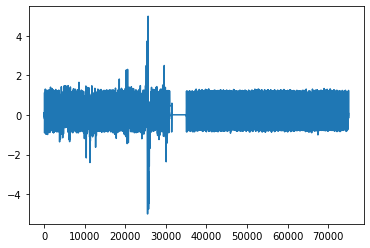

In [21]:
import matplotlib.pyplot as plt

plt.plot(ecg_per_NRS)

In [36]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T

import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
#sys.path.append('DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 300 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


vital_list = pickle.load(open('../Preprocessing/201227_modified_vital','rb'))
input_path = '../DL_model/dataset/preprocess5/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_5min/'
    df_preprocess_pacu = pickle.load(open('../DL_model/cache/preprocess5/df_preprocess_pacu_agender','rb'))
    df_demograph = pickle.load(open('../DL_model/df_caseids+age+gender', 'rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('../DL_model/caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('../DL_model/caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('../DL_model/caseid_val_new', 'rb'))
    
    
    non_lis = []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []
    age_train_pacu, gender_train_pacu = [], []
    age_test_pacu, gender_test_pacu = [], []
    age_val_pacu, gender_val_pacu = [], []

    
    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        if cnt<=9000:
            continue

            
            
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')
        row_demo = df_demograph[df_demograph['caseids']==row['caseids']].iloc[0]
            

        LEN = LEN_PER_NRS*SRATE
        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['PPG']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, LEN)
        #ppg_per_NRS = np.full(LEN, np.nan)
        #ppg_per_NRS[-len(pleth_resamp):] = pleth_resamp
        ppg_per_NRS = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'], 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        #ecg_per_NRS = np.full(LEN,np.nan)
        #ecg_per_NRS[-len(ecg_samp):] = ecg_samp
        ecg_per_NRS = ecg_samp
        
   
        if len(pleth_resamp) != LEN or len(ecg_samp) != LEN:
            print(row['caseids'])
            break
            

        save_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess5/pacu_'+row['file_path']
        # 한 NRS에 대해 23개의 input 확인
        for i in range(23,57):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                if os.path.exists(save_path+'_{}'.format(i)) and row['file_path'] not in vital_list:
                    ppg_inp, ecg_inp = pickle.load(open(save_path+'_{}'.format(i), 'rb'))
                
                else:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000

                    # PPG smoothing
                    ppg_inp = np.copy(ppg_per_NRS[start_idx:end_idx])
                    if np.sum(np.isnan(ppg_inp))!=0:
                        ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    ppg_inp = ppg_inp - smooth(ppg_inp)
                    
                    # ECG smoothing
                    ecg_inp = np.copy(ecg_per_NRS[start_idx:end_idx])
                    if np.sum(np.isnan(ecg_inp))!=0:
                        ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    ecg_inp = ecg_inp - smooth(ecg_inp)                    
                
                    # pickle에 저장
                    pickle.dump([ppg_inp, ecg_inp],  open(save_path+'_{}'.format(i), 'wb'))
                    print('{}...'.format(i+1), end='')
        print('done')
'''                
                # normalization
                pleth_inp = ppg_inp - np.nanmean(ppg_inp)
                ecg_inp2 = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    age_test_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_test_pacu.append(1)
                    else:
                        gender_test_pacu.append(0)
                    x_test_pacu.append([pleth_inp, ecg_inp2])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    age_val_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_val_pacu.append(1)
                    else:
                        gender_val_pacu.append(0)                    
                    x_val_pacu.append([pleth_inp, ecg_inp2])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    age_train_pacu.append(int(row_demo['age']))
                    if row_demo['gender']=='F':
                        gender_train_pacu.append(1)
                    else:
                        gender_train_pacu.append(0)                    
                    x_train_pacu.append([pleth_inp, ecg_inp2])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_lis.append(row['caseids'])
                    
        print('completed')
        
        
    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)
    
    age_train_pacu = np.array(age_train_pacu, int)
    age_test_pacu = np.array(age_test_pacu, int)
    age_val_pacu = np.array(age_val_pacu, int)
    gender_train_pacu = np.array(gender_train_pacu, int)
    gender_test_pacu = np.array(gender_test_pacu, int)
    gender_val_pacu = np.array(gender_val_pacu, int)
    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu2.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu2.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu2.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu2.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu2.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu2.npz', y_val_pacu)
    
    np.savez_compressed(input_path+'age_train_pacu2.npz', age_train_pacu)
    np.savez_compressed(input_path+'age_test_pacu2.npz', age_test_pacu)
    np.savez_compressed(input_path+'age_val_pacu2.npz', age_val_pacu)    
    np.savez_compressed(input_path+'gender_train_pacu2.npz', gender_train_pacu)
    np.savez_compressed(input_path+'gender_test_pacu2.npz', gender_test_pacu)
    np.savez_compressed(input_path+'gender_val_pacu2.npz', gender_val_pacu)    
    
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))
'''

loading data 9001/9949 ...done
loading data 9002/9949 ...done
loading data 9003/9949 ...done
loading data 9004/9949 ...done
loading data 9005/9949 ...done
loading data 9006/9949 ...24...25...26...27...28...29...30...31...33...34...35...36...37...38...39...40...done
loading data 9007/9949 ...done
loading data 9008/9949 ...done
loading data 9009/9949 ...done
loading data 9010/9949 ...done
loading data 9011/9949 ...done
loading data 9012/9949 ...done
loading data 9013/9949 ...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...done
loading data 9014/9949 ...done
loading data 9015/9949 ...done
loading data 9016/9949 ...done
loading data 9017/9949 ...done
loading data 9018/9949 ...done
loading data 9019/9949 ...done
loading data 9020/9949 ...done
loading data 9021/9949 ...done
loading data 9022/9949 ...done
loading data 9023/9949 ...done
loading data 9024/9949 ...done
loading data 9025/9949 ...done
loading data 90

loading data 9253/9949 ...done
loading data 9254/9949 ...done
loading data 9255/9949 ...done
loading data 9256/9949 ...done
loading data 9257/9949 ...done
loading data 9258/9949 ...done
loading data 9259/9949 ...done
loading data 9260/9949 ...done
loading data 9261/9949 ...done
loading data 9262/9949 ...done
loading data 9263/9949 ...done
loading data 9264/9949 ...done
loading data 9265/9949 ...done
loading data 9266/9949 ...done
loading data 9267/9949 ...done
loading data 9268/9949 ...done
loading data 9269/9949 ...done
loading data 9270/9949 ...done
loading data 9271/9949 ...done
loading data 9272/9949 ...done
loading data 9273/9949 ...done
loading data 9274/9949 ...done
loading data 9275/9949 ...done
loading data 9276/9949 ...done
loading data 9277/9949 ...done
loading data 9278/9949 ...done
loading data 9279/9949 ...done
loading data 9280/9949 ...done
loading data 9281/9949 ...done
loading data 9282/9949 ...done
loading data 9283/9949 ...done
loading data 9284/9949 ...done
loading 

loading data 9513/9949 ...27...31...32...33...34...35...done
loading data 9514/9949 ...done
loading data 9515/9949 ...done
loading data 9516/9949 ...done
loading data 9517/9949 ...done
loading data 9518/9949 ...done
loading data 9519/9949 ...done
loading data 9520/9949 ...done
loading data 9521/9949 ...done
loading data 9522/9949 ...done
loading data 9523/9949 ...done
loading data 9524/9949 ...done
loading data 9525/9949 ...done
loading data 9526/9949 ...done
loading data 9527/9949 ...done
loading data 9528/9949 ...done
loading data 9529/9949 ...done
loading data 9530/9949 ...done
loading data 9531/9949 ...done
loading data 9532/9949 ...done
loading data 9533/9949 ...done
loading data 9534/9949 ...done
loading data 9535/9949 ...done
loading data 9536/9949 ...done
loading data 9537/9949 ...done
loading data 9538/9949 ...done
loading data 9539/9949 ...28...29...30...31...32...33...57...done
loading data 9540/9949 ...done
loading data 9541/9949 ...done
loading data 9542/9949 ...done
loadi

"                \n                # normalization\n                pleth_inp = ppg_inp - np.nanmean(ppg_inp)\n                ecg_inp2 = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)\n                \n                \n                # 해당 caseid가 test set에 속하는 경우\n                if row['caseids'] in caseid_test:\n                    age_test_pacu.append(int(row_demo['age']))\n                    if row_demo['gender']=='F':\n                        gender_test_pacu.append(1)\n                    else:\n                        gender_test_pacu.append(0)\n                    x_test_pacu.append([pleth_inp, ecg_inp2])\n                    y_test_pacu.append(int(float(row['NRS'])))\n\n                # 해당 caseid가 train set에 해당하는 경우\n                elif row['caseids'] in caseid_val:\n                    age_val_pacu.append(int(row_demo['age']))\n                    if row_demo['gender']=='F':\n                        gender_val_pacu.append(1)\n                    else:\n          

# Validation - preprocess 6

## lowess filtering

pacu_4.0,5840,PACU1_7_200612_101048.vital_27


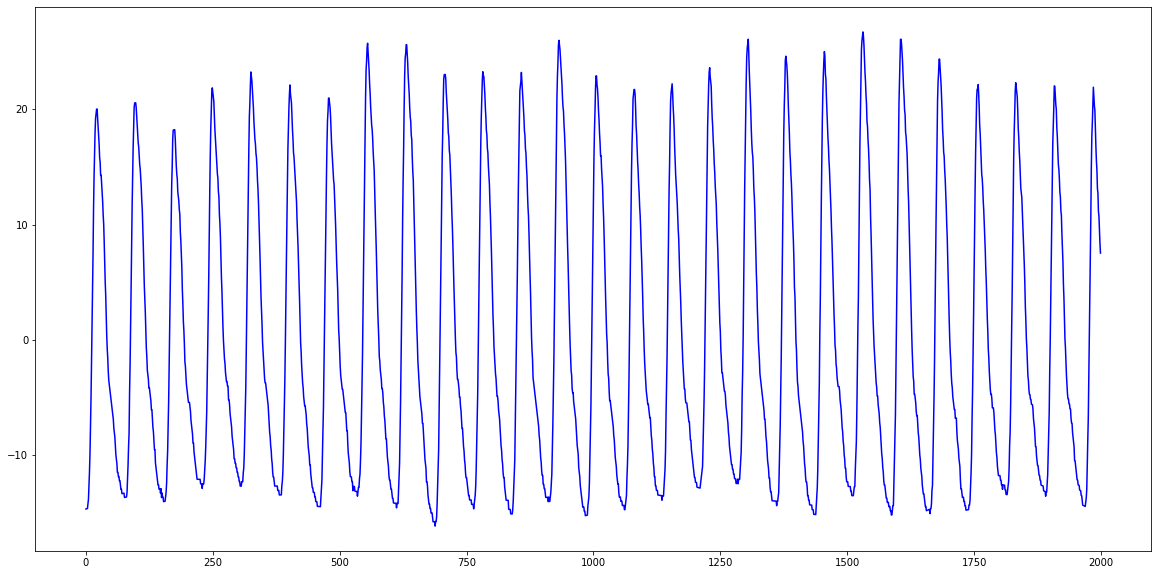

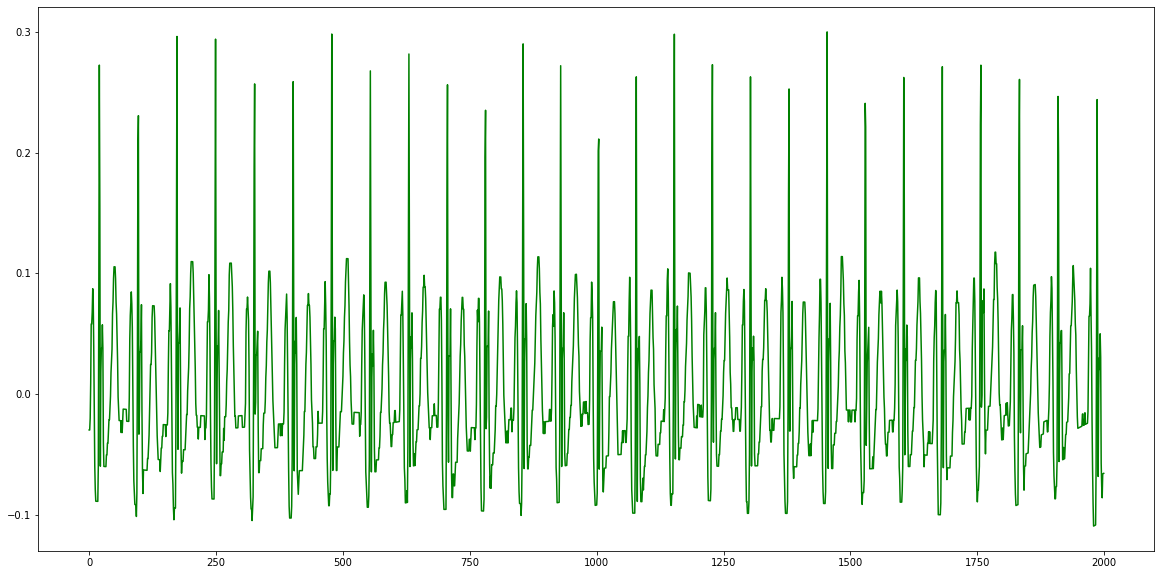

In [38]:
import os, random, pickle
import matplotlib.pyplot as plt


lowess_path = '../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess6'
lowess_list = os.listdir(lowess_path)

idx = random.randint(0, len(lowess_list)-1)
file = lowess_list[idx]
print('idx: {}, file: {}'.format(idx,file))


ppg_f, ecg_f = pickle.load(open(os.path.join(lowess_path, file), 'rb'))

plt.figure(figsize=(20,10))
plt.plot(ppg_f, 'b')

plt.figure(figsize=(20,10))
plt.plot(ecg_f, 'g')

In [39]:
input_path = 'dataset/preprocess4/input1/'

# loading pacu
print('loading data...', flush=True, end='')
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']

loading pacu data...

51922


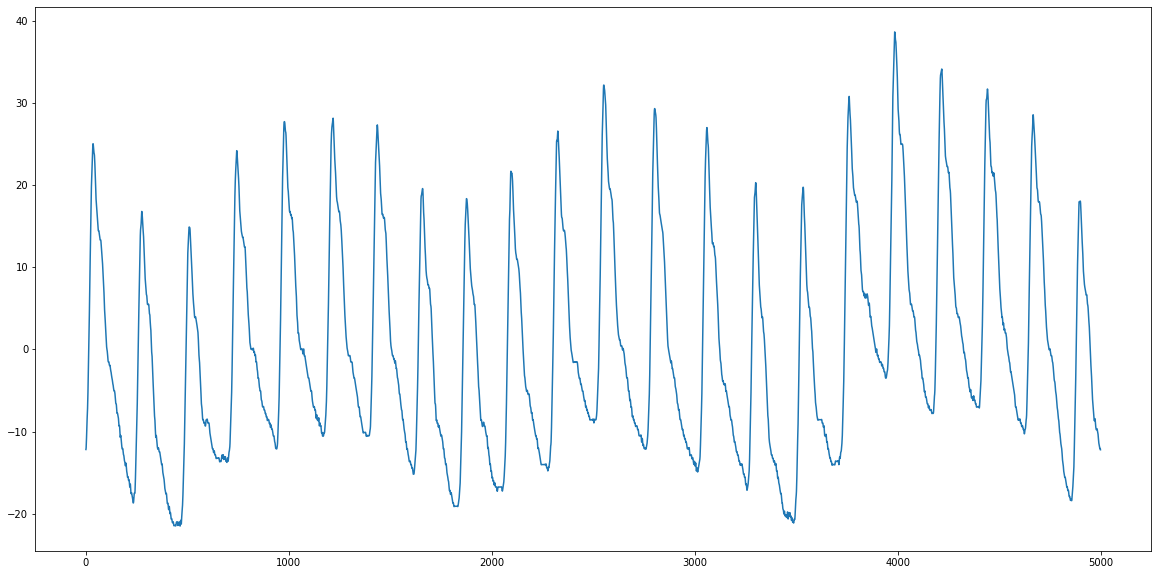

In [44]:
idx = random.randint(0, len(x_train))-1
x_ppg = x_train[idx,:,0]

print(idx)
plt.figure(figsize=(20,10))
plt.plot(x_ppg)

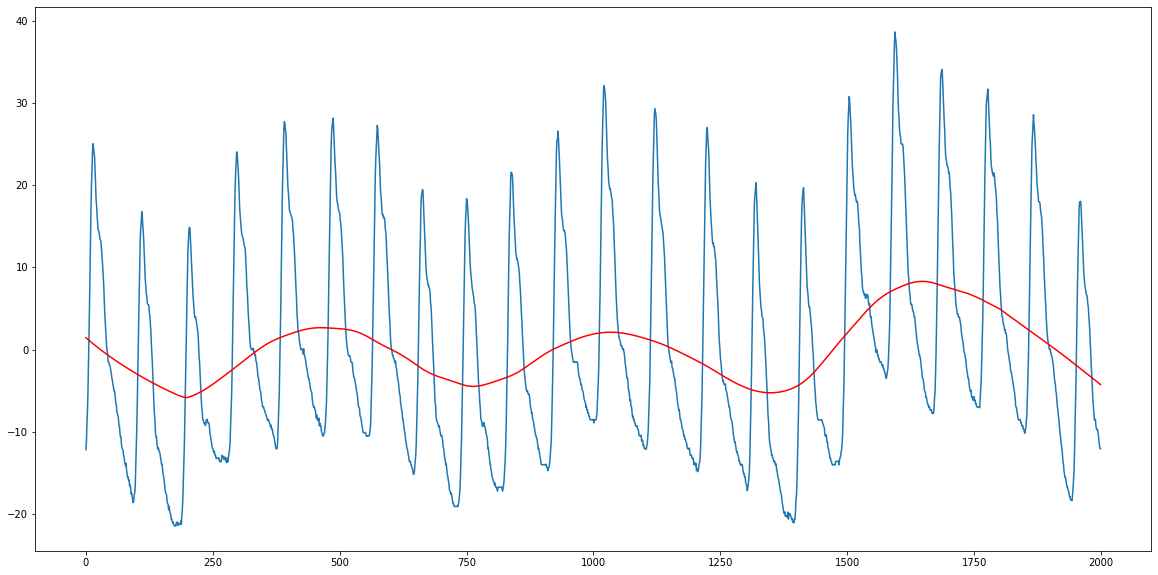

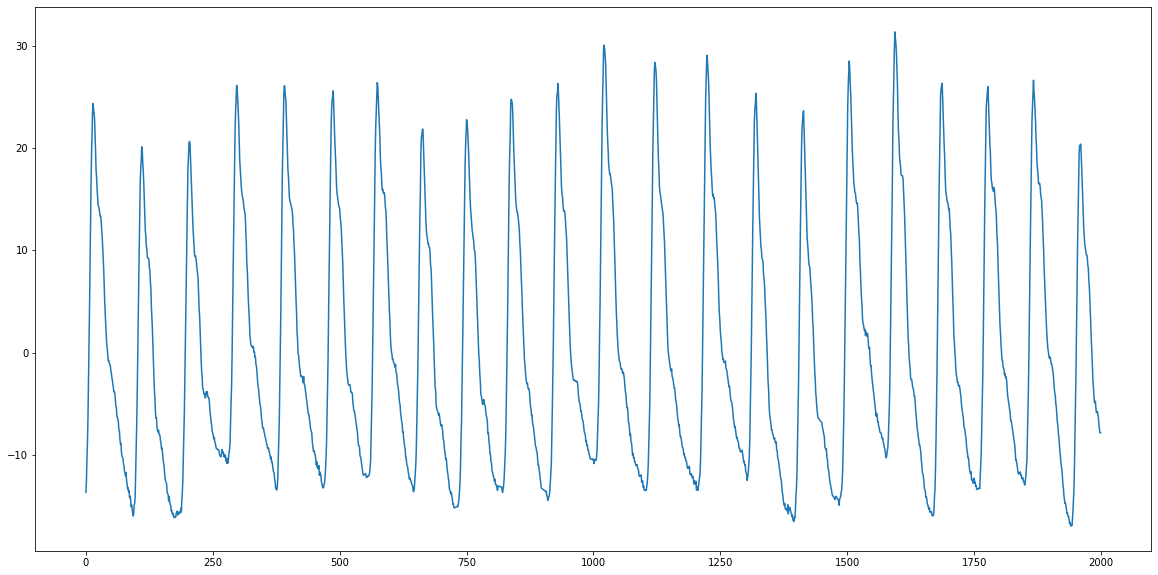

In [48]:
from scipy import signal 
x_ppg = signal.resample(x_ppg, 20*100)

plt.figure(figsize=(20,10))
plt.plot(x_ppg)
plt.plot(smooth(x_ppg), 'r')

plt.figure(figsize=(20,10))
plt.plot(x_ppg - smooth(x_ppg))

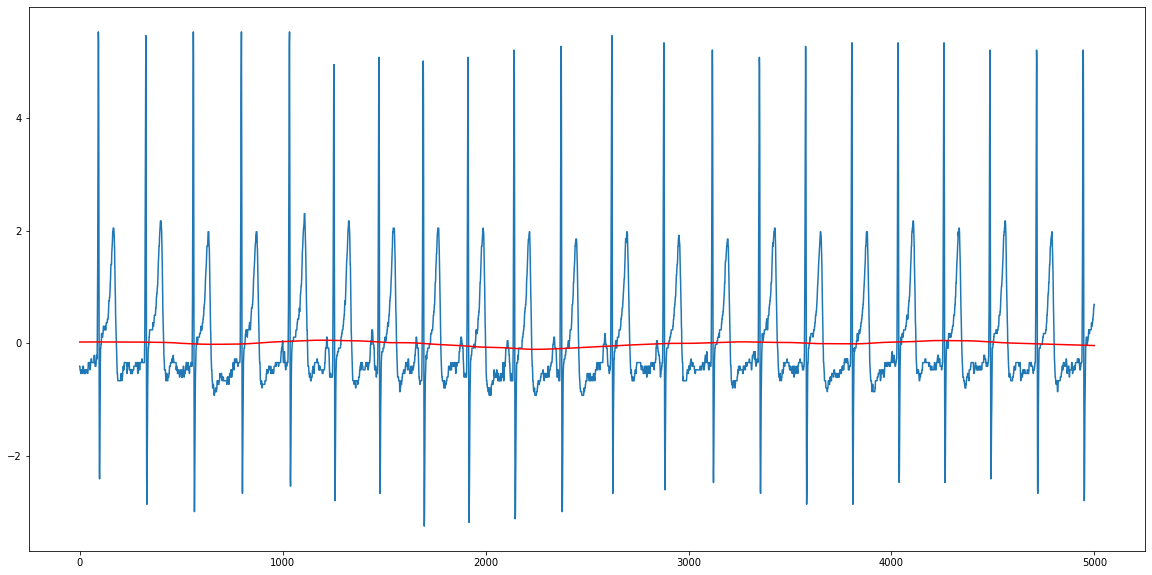

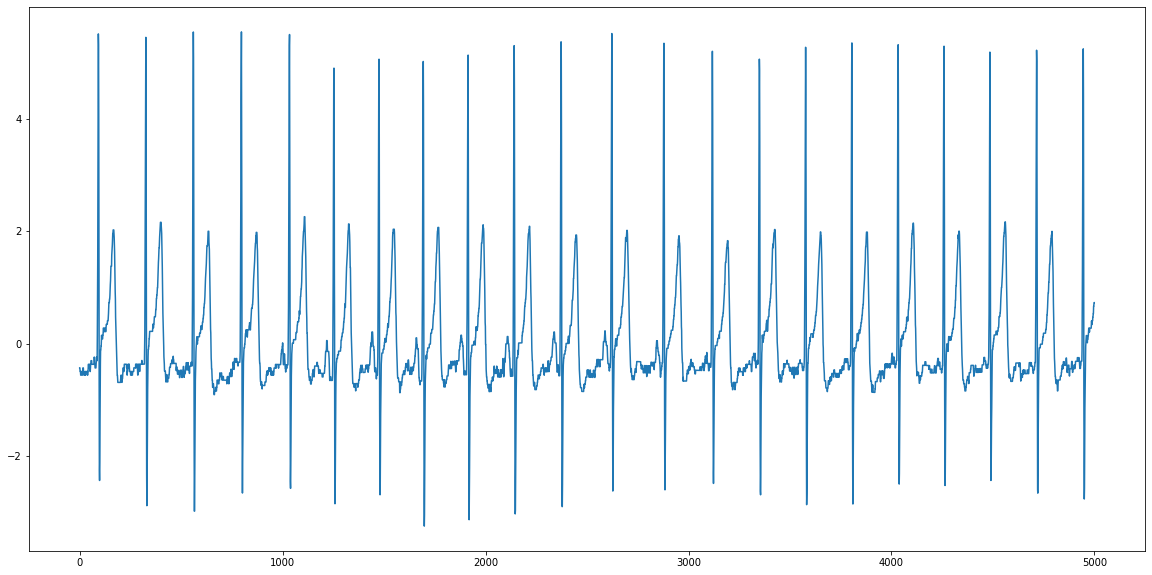

In [49]:
from scipy import signal 
x_ecg = x_train[idx,:,1]
#x_ecg = signal.resample(x_ecg, 20*100)

plt.figure(figsize=(20,10))
plt.plot(x_ecg)
plt.plot(smooth(x_ecg), 'r')

plt.figure(figsize=(20,10))
plt.plot(x_ecg - smooth(x_ecg))

In [45]:
import statsmodels.api as sm


def smooth(y):
    #return savitzky_golay(y, window_size=2001, order=3)
    return lowess(y)

# 0.2가 제일 잘 없앴음
def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T